# Bidirectional Encoder Representations from Transformers

## Abstract

This notebook explores the BERT transformer proposed, in 2018, by Google in the [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) paper. Additionally, it uses the 🤗Hugging Face library to fine-tune a pretrained BERT transformer on the the NLP task of NER tagging.

## Table of Contents

>[Bidirectional Encoder Representations from Transformers](#scrollTo=zuQ-BCQZbiEm)

>>[Abstract](#scrollTo=Dao878vebjFL)

>>[Table of Contents](#scrollTo=MRjfviTibnxY)

>>[Background](#scrollTo=VhqYWLREb-W7)

>>>[Transformer Architecture](#scrollTo=VhqYWLREb-W7)

>>[Token Classification](#scrollTo=JqCbOLl9WcdF)

>>>[Named Entities](#scrollTo=4uK9DfnUg-x2)

>>>[Named-Entity Recognition](#scrollTo=4uK9DfnUg-x2)

>>[Introduction](#scrollTo=UUWNe_gdcv5a)

>>[BERT](#scrollTo=aEjIsIW-cAJu)

>>[BERT Vs the Original Transformer](#scrollTo=pc1H9-m_1bmi)

>>[BERT Implementation Details](#scrollTo=mmbcxRCmg76N)

>>>[BERT's Model Architecture](#scrollTo=3haYvun_2VEF)

>>>[Input Representation](#scrollTo=QtoHwYSm2W_o)

>>>[Output Representation](#scrollTo=ZXo8feuV2ZVH)

>>>[Special Tokens](#scrollTo=1tT99vSI2yXX)

>>[Pre-training BERT](#scrollTo=DrP9FIjimn3f)

>>>[Masked Language Model (MLM)](#scrollTo=DrP9FIjimn3f)

>>>[Next Sentence Prediction (NSP)](#scrollTo=DrP9FIjimn3f)

>>[Fine-tuning BERT](#scrollTo=oO0wYGeuph5U)

>>[Fine-Tuning BERT For NER](#scrollTo=w_TaT9WWr85l)

>>>[Setup](#scrollTo=1hwtgehOtMjN)

>>>[Imports](#scrollTo=DzmJ3pt0tU00)

>>>[Download the Dataset](#scrollTo=C7pQDabLtXlX)

>>>[Preprocessing the Dataset](#scrollTo=zHIO02CztlsI)

>>>>[Input Formatting for BERT](#scrollTo=XRPhB8T-P4M8)

>>>>[Tokenization Misalignment](#scrollTo=wnqajpV_8PzP)

>>>[Data Collation](#scrollTo=cZwfMp8tKedu)

>>>[Model Creation](#scrollTo=7YGauqXHKjvO)

>>>[Model Training](#scrollTo=d3YzRpdP6c4-)

>>>[Model Evaluation](#scrollTo=h3KlL1NjjU9C)

>>>[Model Inference](#scrollTo=-cQrnVuRl1QF)



## Background

In 2017, researchers at Google published a paper called [Attention Is All You Need](https://arxiv.org/abs/1706.03762) that proposed a novel neural network architecture for sequence modeling. Dubbed the **Transformer**, this architecture outperformed recurrent neural networks on machine translation tasks, both in terms of translation quality and training cost.

### Transformer Architecture

Transformers follow the encoder-decoder structure. The encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $z = (z_1, ..., z_n)$. Given $z$, the decoder then generates an output sequence $(y_1, ..., y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of the following figure, respectively.

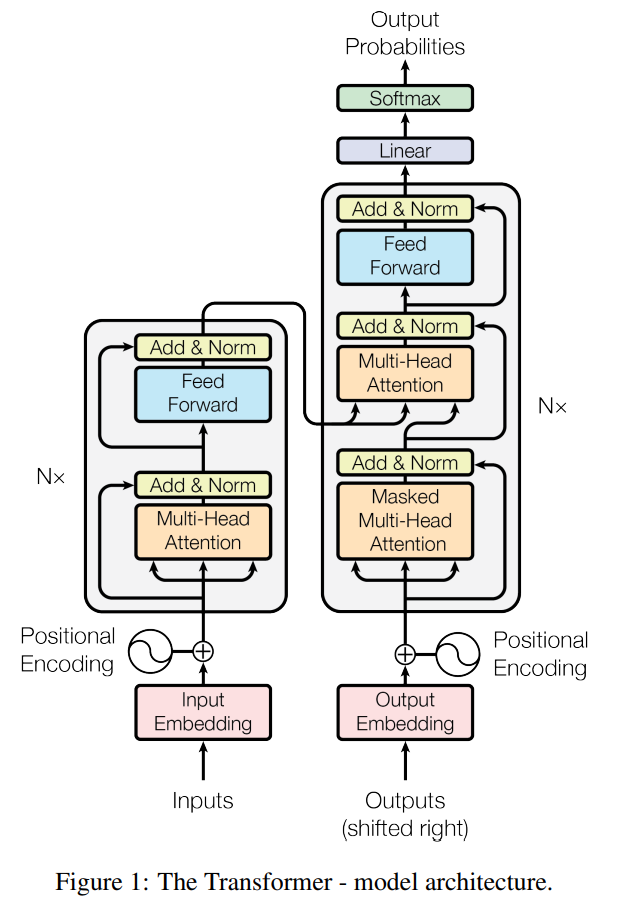

## Token Classification

Token classification encompasses any NLP task that can be formulated as “attributing a label to each token in a sentence,” such as:

- **Part-of-speech tagging** (POS): Mark each word in a sentence as corresponding to a particular part of speech (such as noun, verb, adjective, etc.).

- **Named entity recognition** (NER): Find the entities (such as persons, locations, or organizations) in a sentence. This can be formulated as attributing a label to each token by having one class per entity and one class for “no entity.”

- **Chunking**: Find the tokens that belong to the same entity. This task (which can be combined with POS or NER) can be formulated as attributing one label (usually B-) to any tokens that are at the beginning of a chunk, another label (usually I-) to tokens that are inside a chunk, and a third label (usually O) to tokens that don’t belong to any chunk.



### Named Entities

A named entity is a real-world object, such as a person, location, organization, product, etc., that can be denoted with a proper name. It can be abstract or have a physical existence. Examples of named entities include Barack Obama, New York City, Volkswagen Golf, or anything else that can be named.


### Named-Entity Recognition

Named entity recognition (NER) is the task of
- Identifying and 
- Categorizing entities in text.

Identifying entities involves detecting a word or string of words that form an entity. Each word represents a token: “The Great Lakes” is a string of three tokens that represents one entity. **Inside-outside-beginning** tagging is a common way of indicating where entities begin and end. This approach is called  BIO notation, which differentiates the beginning (B) and the inside (I) of entities.

The second step consists of the classification of the identified entity into one of the following entity categories:

- Person
- Organization
- Time
- Location

These are general entities that can be extended with domain specific ones.



## Introduction

Language model pre-training has been shown to be effective for improving many natural language processing tasks. There are two existing strategies for applying pre-trained language representations to downstream tasks:

- The **feature-based** approach, such as ELMo ([Deep Contextualized Word Representations](https://arxiv.org/abs/1802.05365)), uses task-specific architectures that
include the pre-trained representations as additional features.

- The fine-tuning approach, such as the Generative Pre-trained Transformer (OpenAI GPT) ([Improving Language Understanding by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)), introduces minimal
task-specific parameters, and is trained on the downstream tasks by simply fine-tuning all pretrained parameters.

The BERT paper argues that, at the time, the techniques used restricted the
power of the pre-trained representations, especially for the fine-tuning approaches. The major limitation was that standard language models were
unidirectional, which could be very harmful when applying finetuning based approaches to token-level tasks such as question answering, where it is crucial to incorporate context from both directions.

For example, in OpenAI GPT, the authors use a left-toright architecture, where every token can only attend to previous tokens in the self-attention layers
of the Transformer. Such restrictions are sub-optimal for tasks where it is crucial to incorporate context from both directions.


## BERT

Bidirectional Encoder Representations from Transformers ([BERT](https://arxiv.org/abs/1810.04805)) is a language representation transformer-based model released by google in late 2018. It is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right contexts in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks.

In order to improve the fine-tuning approach to applying pre-trained language representations to downstream tasks, the paper proposes BERT. BERT alleviates the previously mentioned unidirectionality constraint by using a “masked language model” (MLM) pre-training objective.

The masked language model randomly masks some of the tokens from the input, and the objective is to predict the original vocabulary id of the masked word based only on its context. Unlike left-toright language model pre-training, the MLM objective enables the representation to fuse the left and the right context, which allows us to pretrain a deep bidirectional Transformer. In addition to the masked language model, they also use a “next sentence prediction” task that jointly pretrains text-pair representations. The paper shows:

- The importance  of bidirectional pre-training for language representations.
- That pre-trained representations reduce the need for many heavily-engineered taskspecific architectures. BERT is the first finetuning based representation model that achieves state-of-the-art performance on a large suite of sentence-level and token-level tasks, outperforming many task-specific architectures.

## BERT Vs the Original Transformer

BERT is a language model, i.e. it represents the statistical relationships of the words in a language. Hence the "Representations" in its name, Bidirectional Encoder Representations from Transformers.

BERT can be trained in an unsupervised way for representation learning, and then it can be fine-tuned BERT on downstream tasks in a supervised fashion (i.e. transfer learning). On the other hand, the original transformed was not originally conceived to be a language model, but to solve sequence transduction tasks (i.e. converting one sequence to another, such as machine translation) without recurrent connections (or convolutions) but only attention.

## BERT Implementation Details

There are two steps in BERT's framework: 
- Pre-training 
- Fine-tuning

During pre-training, the model is trained on unlabeled data over different pre-training tasks. For finetuning, the BERT model is first initialized with
the pre-trained parameters, and all of the parameters are fine-tuned using labeled data from the downstream tasks. Each downstream task has separate fine-tuned models, even though they are initialized with the same pre-trained parameters. For example, shown below is a question-answering instance which illustrates BERT's framework.

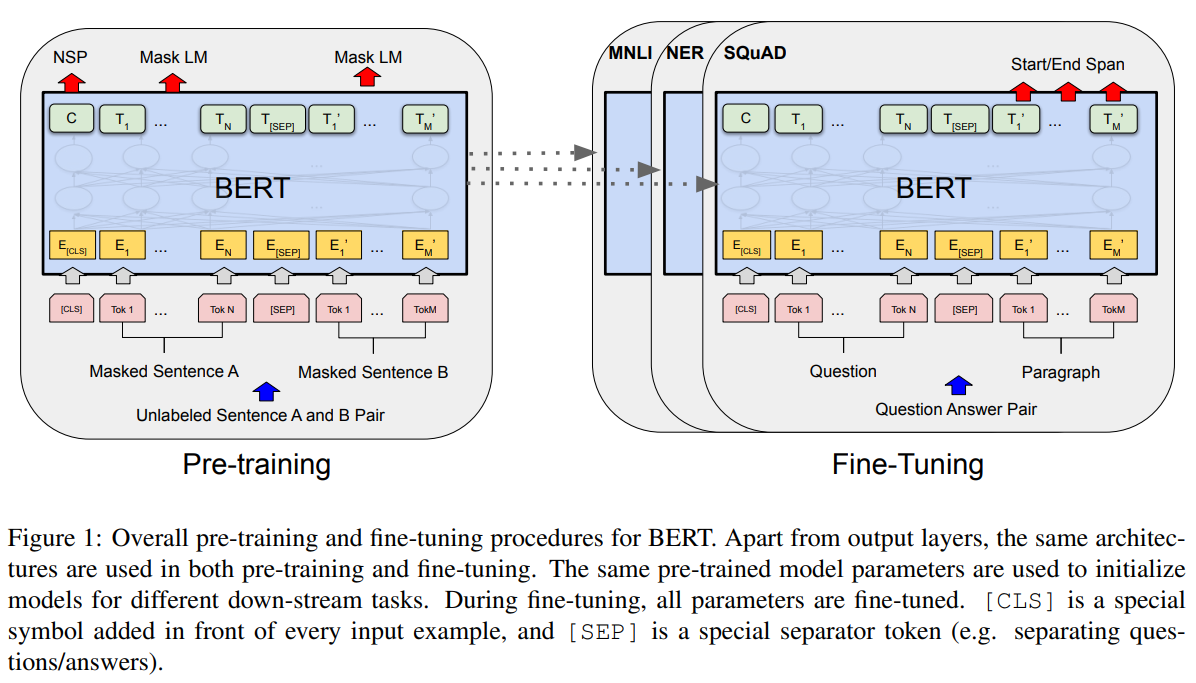

### BERT's Model Architecture

BERT’s model architecture is a multi-layer bidirectional Transformer encoder based on the original Transformer implementation. There are two BERT model variants: BERT-BASE and BERT-LARGE. The differ solely in the model size and number of parameters as shown below.

- BERT-BASE ($L=12$, $H=768$, $A=12$, Total Parameters$=110M$)
- BERT-LARGE ($L=24$, $H=1024$, $A=16$, Total Parameters$=340M$).

### Input Representation

To make BERT handle a variety of down-stream tasks, the input representation is able to unambiguously represent both a single sentence and a pair of sentences. Thus, a “sequence” refers to the input token sequence to BERT, which may be a single sentence or two sentences packed together. BERT uses WordPiece embeddings with a vocabulary size of $30,000$ tokens. 

The first token of every sequence is always a special classification token `[CLS]`. Sentence pairs are packed together into a single sequence. We differentiate the sentences in two ways. First, we separate them with a special token `[SEP]`. Second, we add a learned embedding to every token indicating whether it belongs to sentence A or sentence B.

### Output Representation

The final hidden state corresponding to the classifcation `[CLS]` token is used as the aggregate sequence representation $C \in R^H$ for classification tasks. The final hidden vector of the $i^{th}$ input token is $T_i \in R^H$.

As shown in the figure below, for a given token, its input representation is constructed by summing the corresponding token, segment, and position embeddings. 

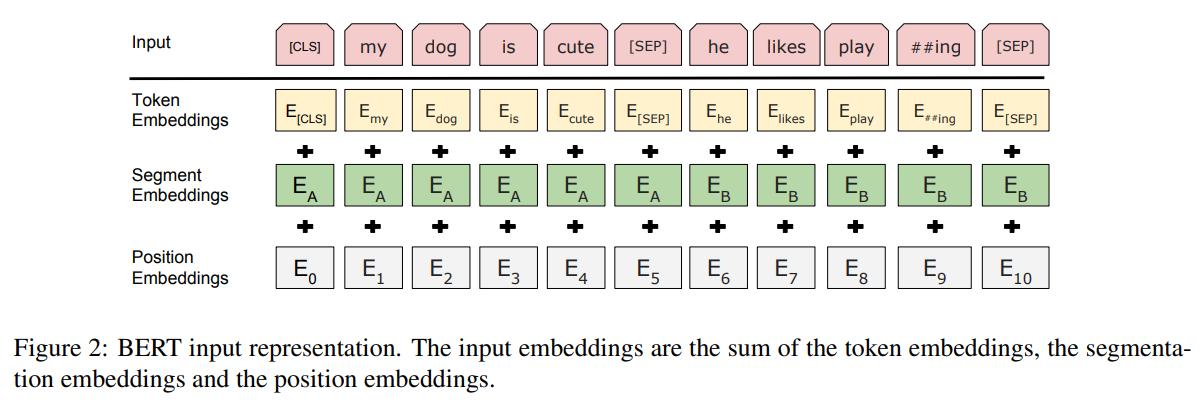


### Special Tokens

**`[SEP]`**

A special `[SEP]` token must be appeneded at the end of every sentence. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g. can the answer to the question in sentence A be found in sentence B?). 

**`[CLS]`**

For classification tasks, a special `[CLS]` token must be prepended to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings at the output. At the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.


> From the BERT paper: "The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks."

**`[PAD]`**

BERT handles sentences of varying constraints by forcing all sentences' tokens to be padded/truncated into a single, fixed-length (maximum sentence length supported by BERT is 512). Padding is done by a special `[PAD]` token, which corresponds to index 0 in BERT's vocabulary. Additionally, an attention mask should specify which tokens are padding and which aren't.

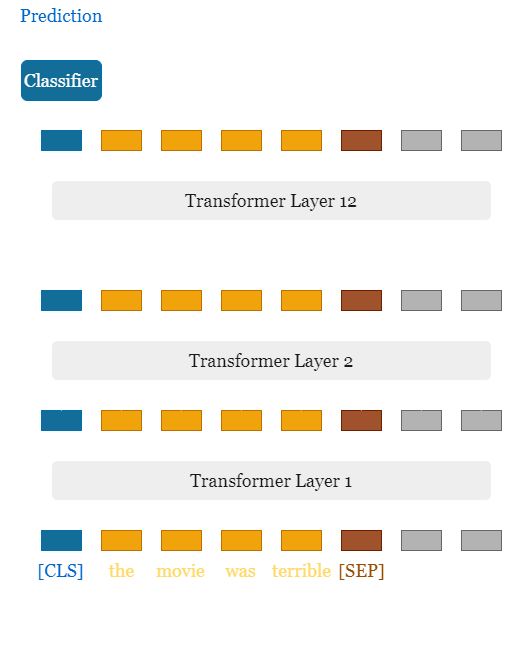

## Pre-training BERT

BERT is pre-trained using the following two supervised tasks.

### Masked Language Model (MLM)

In order to train a deep bidirectional representation, a certain percentage ($15\%$ of all WordPiece tokens) of the input is masked at random, and then the model is trained to predict those masked tokens.

### Next Sentence Prediction (NSP)

Many important downstream tasks such as Question Answering (QA) are based on understanding the relationship between two sentences, which is not directly captured by language modeling. In order to train a model that understands sentence relationships, BERT is pre-trained for a binarized next sentence prediction task that can be trivially generated from any monolingual corpus. Specifically, when choosing the sentences A and B for each pretraining example, 50% of the time B is the actual next sentence that follows A, and 50% of the time it is a random sentence from the corpus. $C$ is used for next sentence prediction (NSP).

## Fine-tuning BERT

For each task, we simply plug in the taskspecific inputs and outputs into BERT and finetune all the parameters end-to-end. At the input, sentence A and sentence B from pre-training are analogous to 

1. sentence pairs in paraphrasing, 
2. hypothesis-premise pairs in entailment,
3. question-passage pairs in question answering, 
4. a degenerate text-∅ pair in text classification
or sequence tagging. 

At the output, the token representations are fed into an output layer for token-level tasks, such as sequence tagging or question
answering, and the `[CLS]` representation is fed
into an output layer for classification, such as entailment or sentiment analysis.

## Fine-Tuning BERT For NER

### Setup

In [1]:
!pip install transformers datasets evaluate seqeval -q

     |████████████████████████████████| 5.3 MB 7.5 MB/s 
     |████████████████████████████████| 441 kB 70.9 MB/s 
     |████████████████████████████████| 72 kB 1.5 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 
     |████████████████████████████████| 163 kB 73.3 MB/s 
     |████████████████████████████████| 212 kB 69.7 MB/s 
     |████████████████████████████████| 115 kB 61.9 MB/s 
     |████████████████████████████████| 95 kB 5.1 MB/s 
     |████████████████████████████████| 127 kB 79.3 MB/s 
     |████████████████████████████████| 115 kB 74.4 MB/s 


### Imports

In [2]:
import numpy as np

import evaluate

from datasets import load_dataset
from datasets import load_metric

from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForTokenClassification
from transformers import TrainingArguments, Trainer, create_optimizer
from transformers import DataCollatorForTokenClassification

### Download the Dataset


Download the [WikiANN](https://huggingface.co/datasets/wikiann/viewer/en/train) dataset, from the 🤗Datasets library. It consists of Wikipedia articles annotated with LOC (location), PER (person), and ORG (organisation) tags in the IOB2 format.

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation, and test sets. To access an instance element, a split should first be specified, then an index.

In [3]:
ds = load_dataset("wikiann", "en")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ds

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [5]:
ner_labels_list = ds["train"].features["ner_tags"].feature.names
ner_labels_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

### Preprocessing the Dataset

BERT expects a certain formatting for its input. In this section, the dataset is transformed to follow that format. For each sample, we need to get the values for `input_ids`, `token_type_ids` and `attention_mask` as well as adjust the labels.

#### Input Formatting for BERT

To feed text to BERT, the input tensor must contain:

1. The tokenization of the input text by a BERT tokenizer and then mapped to their index in the tokenizer's vocabulary `input_ids`. 

  - The tokenized tensor should be padded/truncated into a fixed length.
  - Include the classification `[CLS]` and the separator `[SEP]` tokens.

2. An `attention_mask` array that differentiates real tokens from padding ones.

3. A `type_ids` array that specifies the sentence id (this is simply an array of zeros because when performing single-sentence classifications).

This is done by a 🤗Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and structure it in a format the model expects, as well as generate the other inputs that model requires.

The tokenizer is instanciated with the `AutoTokenizer.from_pretrained` method, which will ensure:

- Getting a tokenizer that corresponds to the BERT model architecture,
- Downloading the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time the cell is run.

In [6]:
# Specify model's checkpoint
model_checkpoint = "bert-base-cased"

# Instanciate the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

#### Tokenization Misalignment

The WordPiece tokenization used by BERT leads to a misalignment between the input (`token_ids`) and the labels (`ner_tags`) due to:

* The addition of the special `[CLS]` and `[SEP]` tokens.
* The tokenization of words into subwords.

Realigning the tokens and their `ner_tags` consists of:

1. Mapping all tokens to their corresponding word with the `word_ids` method.
2. Assigning the label `-100` to the special tokens `[CLS]` and `[SEP]` so the loss function ignores them.
3. Only labeling the first token of a given word. Assign `-100` to other subtokens from the same word.

This section defines a function which performs the BERT tokenization and alignment of the labels with `token_ids`.

In [7]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

  labels = []
  for i, label in enumerate(examples["ner_tags"]):

    # 1. Map tokens to their respective word.
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx = None

    # 2. Set the special tokens to -100.
    label_ids = []
    for word_idx in word_ids:  
        if word_idx is None:
            label_ids.append(-100)

        # 3. Only label the first token of a given word.
        elif word_idx != previous_word_idx:
            label_ids.append(label[word_idx])
        else:
            label_ids.append(-100)
        previous_word_idx = word_idx
    labels.append(label_ids)

  tokenized_inputs["labels"] = labels
  return tokenized_inputs

Then, the 🤗Datasets `map` function applies the preprocessing function over the entire dataset. The function is sped up by setting `batched=True` as it processes multiple elements of the dataset at once.

In [8]:
tokenized_ds = ds.map(
    tokenize_and_align_labels, 
    batched=True,
    remove_columns=ds["train"].column_names
    )

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

### Data Collation

In [24]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
batch_size = 8

tf_train_dataset = tokenized_ds["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=batch_size
)

tf_val_dataset = tokenized_ds["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8
)

tf_test_dataset = tokenized_ds["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels", "token_type_ids"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=8
)

### Model Creation

In [26]:
# NER tags-labels correspondences
id2label = {i: label for i, label in enumerate(ner_labels_list)}
label2id = {v: k for k, v in id2label.items()}

In [27]:
model = TFAutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model Training

In [28]:
num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [29]:
model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=num_epochs
)

Epoch 1/3
2500/2500 [==============================] - 339s 117ms/step - loss: 0.3303 - val_loss: 0.2411
Epoch 2/3
2500/2500 [==============================] - 300s 120ms/step - loss: 0.1805 - val_loss: 0.2266
Epoch 3/3
2500/2500 [==============================] - 286s 114ms/step - loss: 0.1183 - val_loss: 0.2389


### Model Evaluation

The traditional framework used to evaluate token classification prediction is [seqeval](https://github.com/chakki-works/seqeval). This metric does not behave like the standard accuracy: it takes the lists of labels as strings, not integers, so the predictions and labels must be decoded before passing them to the metric.  

In [30]:
metric = evaluate.load("seqeval")

TensorFlow can't concatenate the predictions together, because they have variable sequence lengths. This means model.predict() can't be used directly on an entire dataset. However, it can be used to obtain the predictions of one batch at a time, which are then concatenated into a one list. Finally, the -100 tokens that indicate masking/padding are dropped, then the metric is computed on the list at the end:

In [ ]:
all_predictions = []
all_labels = []

for batch in tf_val_dataset:
    
  # Get the model's predictions on the current batch
  logits = model.predict(batch)["logits"]
  predictions = np.argmax(logits, axis=-1)

  # Get the true labels for the current batch
  labels = batch["labels"]
  
  # Append the predictions and labels to their corresponding lists
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):

      # Discard padding/masking tokens
      if label_idx == -100:
          continue

      all_predictions.append(ner_labels_list[predicted_idx])
      all_labels.append(ner_labels_list[label_idx])

In [32]:
model_performance_dict = metric.compute(predictions=[all_predictions], references=[all_labels])

for k in model_performance_dict:
  print(f"{k}\t{model_performance_dict[k]}")

LOC	{'precision': 0.8413203420163055, 'recall': 0.8752585850227554, 'f1': 0.857953969380513, 'number': 4834}
ORG	{'precision': 0.7402705515088449, 'recall': 0.7605302544366047, 'f1': 0.7502636574562329, 'number': 4677}
PER	{'precision': 0.8853904282115869, 'recall': 0.9100323624595469, 'f1': 0.897542291733163, 'number': 4635}
overall_precision	0.8224414303329223
overall_recall	0.8487204863565673
overall_f1	0.8353743389924855
overall_accuracy	0.9345137578225886


### Model Inference

In [33]:
token_classifier = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
token_classifier("My name is Mike. I live in Italy.")

[{'entity_group': 'PER',
  'score': 0.8799032,
  'word': 'Mike',
  'start': 11,
  'end': 15},
 {'entity_group': 'LOC',
  'score': 0.9944354,
  'word': 'Italy',
  'start': 27,
  'end': 32}]